# Energy-Based models and structured prediction

In this assignment we're going to work with structured prediction. Structured prediction broadly refers to any problem involving predicting structured values, as opposed to plain scalars. Examples of structured outputs include graphs and text.

We're going to work with text. The task is to transcribe a word from an image. The difficulty here is that different words have different lengths, so we can't just have fixed number of outputs.

## Dataset
As always, the first thing to do is implementing the dataset. We're going to create a dataset that creates images of random words. We'll also include some augmentations, such as jitter (moving the character horizontally).

In [1]:
! mkdir fonts
! curl --output fonts/font.zip https://www.fontsquirrel.com/fonts/download/Anonymous
! unzip -n fonts/font.zip -d fonts

mkdir: cannot create directory ‘fonts’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29805  100 29805    0     0  59849      0 --:--:-- --:--:-- --:--:-- 59729
Archive:  fonts/font.zip


torch.Size([32, 18])


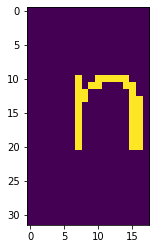

In [2]:
from PIL import ImageDraw, ImageFont
import string
import random
import torch
import torchvision
from torchvision import transforms
from PIL import Image # PIL is a library to process images
from matplotlib import pyplot as plt

simple_transforms = transforms.Compose([
                                    transforms.ToTensor(), 
                                ])

class SimpleWordsDataset(torch.utils.data.IterableDataset):

  def __init__(self, max_length, len=100, jitter=False, noise=False):
    self.max_length = max_length
    self.transforms = transforms.ToTensor()
    self.len = len
    self.jitter = jitter
    self.noise = noise
  
  def __len__(self):
    return self.len

  def __iter__(self):
    for _ in range(self.len):
        text = ''.join([random.choice(string.ascii_lowercase) for i in range(self.max_length)])
        img = self.draw_text(text, jitter=self.jitter, noise=self.noise)
        yield img, text
  
  def draw_text(self, text, length=None, jitter=False, noise=False):
    if length == None:
        length = 18 * len(text)
    img = Image.new('L', (length, 32))
    fnt = ImageFont.truetype("fonts/Anonymous.ttf", 20)

    d = ImageDraw.Draw(img)
    pos = (0, 5)
    if jitter:
        pos = (random.randint(0, 7), 5)
    else:
        pos = (0, 5)
    d.text(pos, text, fill=1, font=fnt)

    img = self.transforms(img)
    img[img > 0] = 1 
    
    if noise:
        img += torch.bernoulli(torch.ones_like(img) * 0.1)
        img = img.clamp(0, 1)
        

    return img[0]

sds = SimpleWordsDataset(1, jitter=True, noise=False)
img = next(iter(sds))[0]
print(img.shape)
plt.imshow(img)

We can look at what the entire alphabet looks like in this dataset.

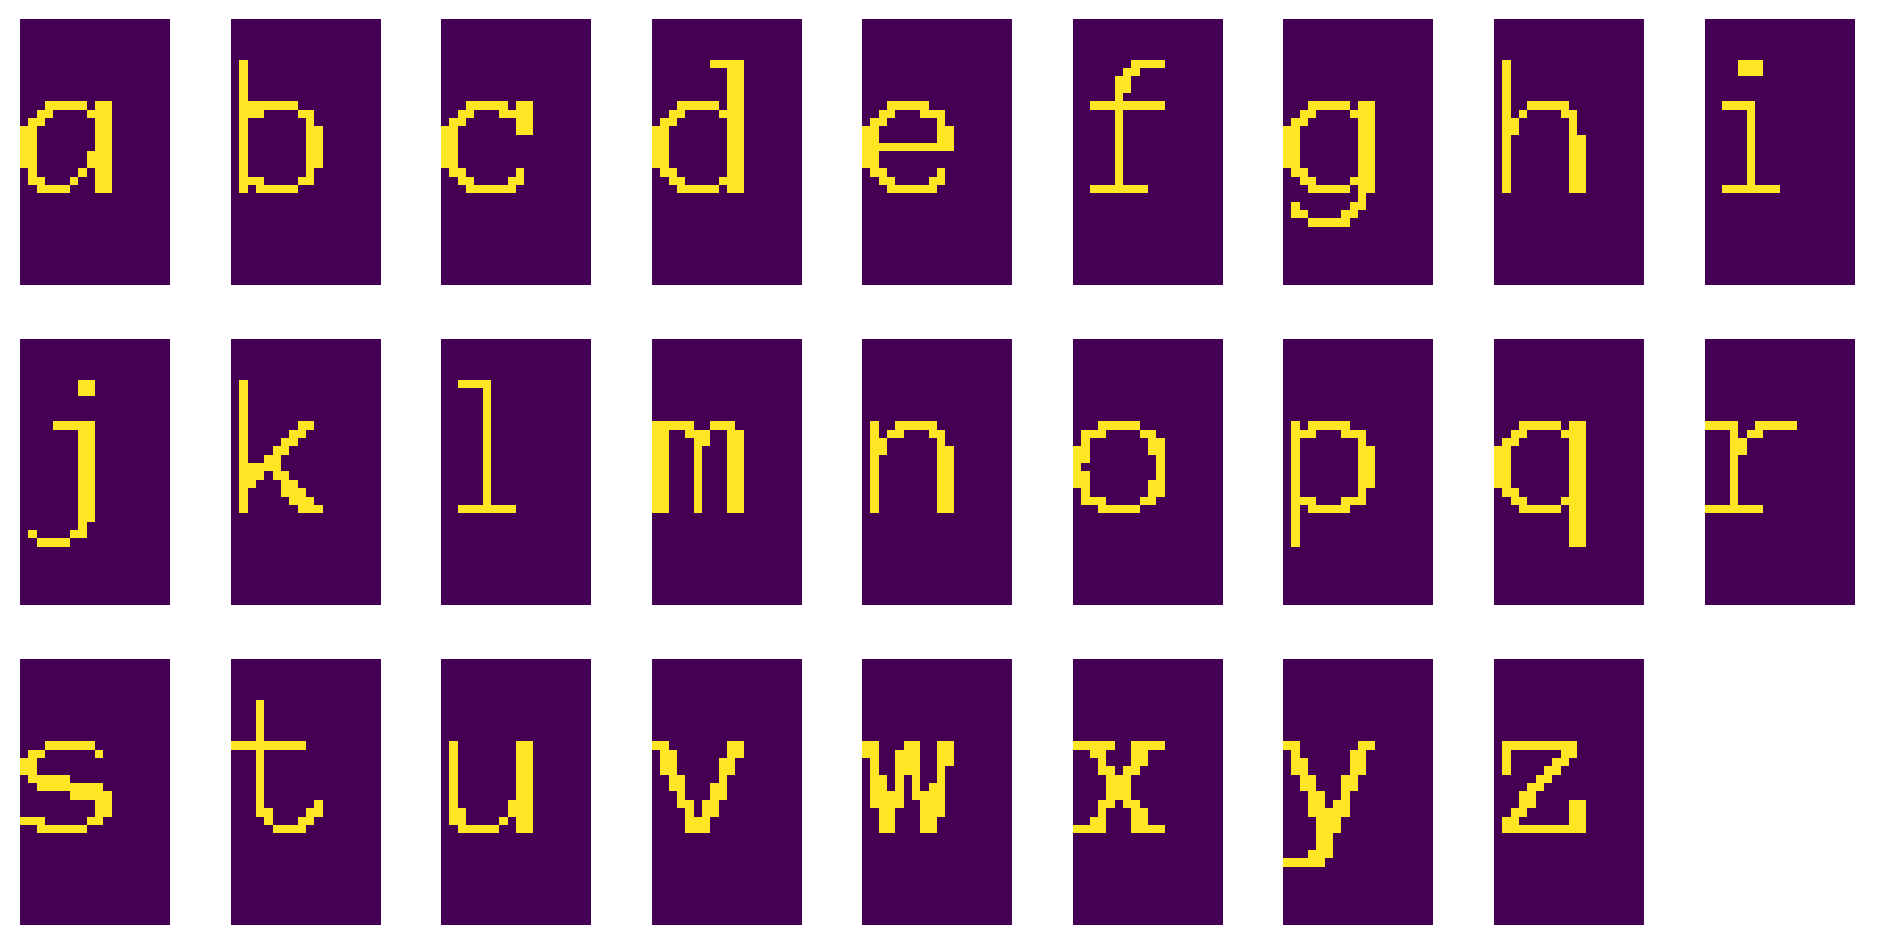

In [3]:
fig, ax = plt.subplots(3, 9, figsize=(12, 6), dpi=200)

for i, c in enumerate(string.ascii_lowercase):
    row = i // 9
    col = i % 9
    ax[row][col].imshow(sds.draw_text(c))
    ax[row][col].axis('off')
ax[2][8].axis('off')
    
plt.show()

We can also put the entire alphabet in one image.

(-0.5, 339.5, 31.5, -0.5)

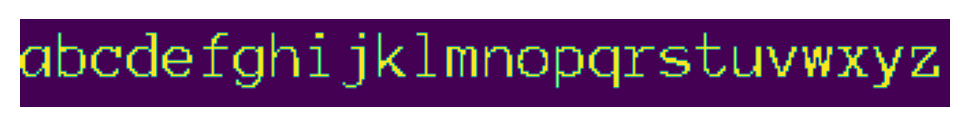

In [4]:
alphabet = sds.draw_text(string.ascii_lowercase, 340)
plt.figure(dpi=200)
plt.imshow(alphabet)
plt.axis('off')

## Model definition
Before we define the model, we define the size of our alphabet. Our alphabet consists of lowercase English letters, and additionally a special character used for space between symbols or before and after the word. For the first part of this assignment, we don't need that extra character.

Our end goal is to learn to transcribe words of arbitrary length. However, first, we pre-train our simple convolutional neural net to recognize single characters. In order to be able to use the same model for one character and for entire words, we are going to design the model in a way that makes sure that the output size for one character (or when input image size is 32x18) is 1x27, and Kx27 whenever the input image is wider. K here will depend on particular architecture of the network, and is affected by strides, poolings, among other things. 
A little bit more formally, our model $f_\theta$, for an input image $x$ gives output energies $l = f_\theta(x)$. If $x \in \mathbb{R}^{32 \times 18}$, then $l \in \mathbb{R}^{1 \times 27}$.
If $x \in \mathbb{R}^{32 \times 100}$ for example, our model may output $l \in \mathbb{R}^{10 \times 27}$, where $l_i$ corresponds to a particular window in $x$, for example from $x_{0, 9i}$ to $x_{32, 9i + 18}$ (again, this will depend on the particular architecture).

Below is a drawing that explains the sliding window concept. We use the same neural net with the same weights to get $l_1, l_2, l_3$, the only difference is receptive field. $l_1$ is looks at the leftmost part, at character 'c', $l_2$ looks at 'a', and $l_3$ looks at 't'. The receptive field may or may not overlap, depending on how you design your convolutions.

![cat.png](https://i.imgur.com/JByfyKh.png)

In [5]:
# constants for number of classes in total, and for the special extra character for empty space
ALPHABET_SIZE = 27
BETWEEN = 26

In [6]:
from torch import nn

class SimpleNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.cnn_block = torch.nn.Sequential(
          # TODO 
            nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),

            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,1), padding = (1,0)),

            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),

            nn.Conv2d(in_channels = 256, out_channels = 27, kernel_size = 2)
        )

    def forward(self, x):
        x = self.cnn_block(x)
        # after applying cnn_block, x.shape should be:
        # x: [batch_size, alphabet_size, height=1, width]
        # x[:, :, 0, :] <=> x.squeeze()  => [batch_size, alphabet_size, width]
        return x[:, :, 0, :].permute(0, 2, 1) # [batch_size, width=1, alphabet_size]

Let's initalize the model and apply it to the alphabet image:

torch.Size([1, 1, 32, 340])


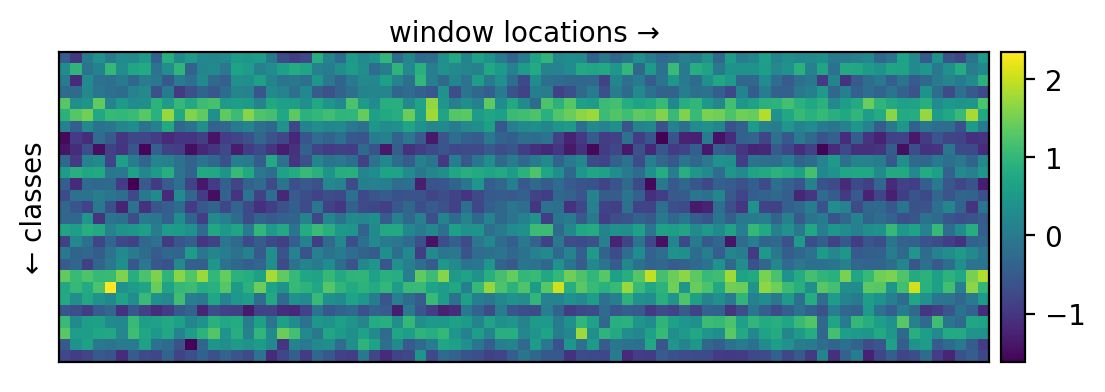

In [7]:
model = SimpleNet()
print(alphabet.view(1, 1, *alphabet.shape).shape)
alphabet_energies = model(alphabet.view(1, 1, *alphabet.shape))

def plot_energies(ce):
    fig=plt.figure(dpi=200)
    ax = plt.axes()
    im = ax.imshow(ce.cpu().T)
    
    ax.set_xlabel('window locations →')
    ax.set_ylabel('← classes')
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([])
    ax.set_yticks([])
    
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax) 
    
plot_energies(alphabet_energies[0].detach())

So far we only see random outputs, because the classifier is untrained.

## Train with one character

Now we train the model we've created on a dataset where images contain only single characters. Note the changed cross_entropy function.

In [8]:
from tqdm.notebook import tqdm

def cross_entropy(energies, *args, **kwargs):
    """ We use energies, and therefore we need to use log soft arg min instead
        of log soft arg max. To do that we just multiply energies by -1. """
    return nn.functional.cross_entropy(-1 * energies, *args, **kwargs)

def simple_collate_fn(samples):
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(lambda c : torch.tensor(ord(c) - ord('a')), annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(images[i], (0, m_width - images[i].shape[-1]))
        
    if len(images) == 1:
        return images[0].unsqueeze(0), torch.stack(annotations)
    else:
        return torch.stack(images), torch.stack(annotations)

sds = SimpleWordsDataset(1, len=1000, jitter=True, noise=False)
dataloader = torch.utils.data.DataLoader(sds, batch_size=16, num_workers=0, collate_fn=simple_collate_fn)

# model = SimpleNet()
model.cuda()

# TODO: train the model on the one-character dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model, batch, optimizer, device):
    x = batch[0].unsqueeze(1).to(device) # torch.Size([16, 32, 18]) => torch.Size([16, 1, 32, 18])
    y = batch[1].to(device)   # torch.Size([16])

    # feed data
    y_hat = model(x).squeeze(1) # torch.Size([16,1,27]) => torch.Size([16,27])
    # loss
    loss = cross_entropy(y_hat, y)
    # zero gradient
    optimizer.zero_grad()
    # back-propagate
    loss.backward()
    # optimize
    optimizer.step()
    
epochs = 15

learning_rate = 1e-3
lambda_l2 = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

pbar = tqdm(range(epochs))
model.train()

for i in pbar:
    for batch in tqdm(dataloader, leave=False):
        train(model, batch, optimizer, device)

In [9]:
def get_accuracy(model, dataset):
    cnt = 0
    for i, l in dataset:
        energies = model(i.unsqueeze(0).unsqueeze(0).cuda())[0, 0]
        x = energies.argmin(dim=-1)
        cnt += int(x == (ord(l[0]) - ord('a')))
    return cnt / len(dataset)
        
tds = SimpleWordsDataset(1, len=100)

print(get_accuracy(model,tds))
assert get_accuracy(model, tds) == 1.0, 'Your model doesn\'t achieve 100% accuracy for 1 character'

1.0


Now, to see how our model would work with more than one character, we apply the model to a bigger input - the image of the alphabet we saw earlier. We extract the energies for each window and show them.

torch.Size([1, 81, 27])


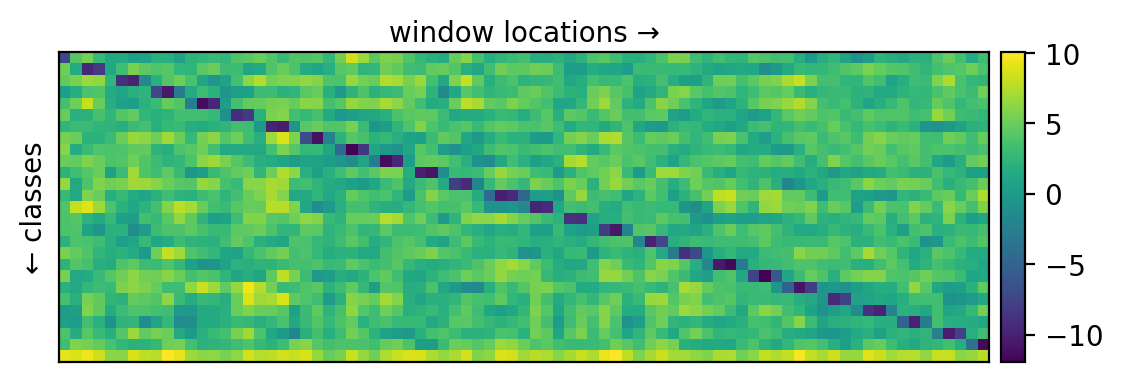

In [10]:
alphabet_energies_post_train = model(alphabet.cuda().view(1, 1, *alphabet.shape))
print(alphabet_energies_post_train.shape)
plot_energies(alphabet_energies_post_train[0].detach())

Explain any classes that are lit up (dark). What is still missing to be able to use it for transcription of words?

Answer: 
Character a-z is sequentially lit up from left to right. Several characters are lit up more than once. The bottom class is not lit up, meaning that there is no space recognition in this model.  

We need to let model to understand the empty space, recognize space in-between and use slide window for transcription of words.

## Training with multiple characters

Now, we want to train our model to not only recognize the letters, but also to recognize space in-between so that we can use it for transcription later.

This is where complications begin. When transcribing a word from an image, we don't know beforehand how long the word is going to be. We can use our convolutional neural network we've pretrained on single characters to get prediction of character probabilities for all the positions of an input window in the new input image, but we don't know beforehand how to match those predictions with the target label. Training with incorrect matching can lead to wrong model, so in order to be able to train a network to transcribe words, we need a way to find these pairings.

![dl.png](https://i.imgur.com/7pnodfV.png)

The importance of pairings can be demonstrated by the drawing above. If we map $l_1, l_2, l_3, l_4$ to 'c', 'a', 't', '_' respectively, we'll correctly train the system, but if we put $l_1, l_2, l_3, l_4$ with 'a', 'a', 't', 't', we'd have a very wrong classifier.

To formalize this, we use energy-based models' framework. Let's define the energy $E(x, y, z)$ as the sum of cross-entropies for a particular pairing between probabilities our model gives for input image $x$ and text transcription $y$, and pairing $z$. $z$ is a function $z : \{1, 2, \dots, \vert l \vert \} \to \{1, 2, \dots, \vert y \vert)$, $l$ here is the energies output of our convolutional neural net $l = f_\theta(x)$. $z$ maps each energy vector in $l$ to an element in the output sequence $y$. We want the mappings to make sense, so $z$ should be a non-decreasing function $z(i) \leq z(i+1)$, and it shouldn't skip characters, i.e. $\forall_i \exists_j z(j)=i$.

Energy is then $E(x, y, z) = C(z) + \sum_{i=1}^{\vert l \vert} l_i[z(i)]$
,  $C(z)$ is some extra term that allows us to penalize certain pairings, and $l_i[z(i)]$ is the energy of $z(i)$-th symbol on position $i$.

In this particular context, we define $C(z)$ to be infinity for impossible pairings:
$$C(z) = \begin{cases}
\infty \; \text{if} \; z(1) \neq 1 \vee z(\vert l \vert) \neq \vert y \vert \vee \exists_{i, 1\leq 1 \leq \vert l \vert - 1} z(i) > z(i+1) \vee z(i) < z(i+1) - 1\\
0 \; \text{otherwise}
\end{cases}
$$


Then, the free energy $F(x, y) = \arg \min_z E(x, y, z)$. In other words, the free energy is the energy of the best pairing between the probabilities provided by our model, and the target labels.

When training, we are going to use cross-entropies along the best path: $\ell(x, y, z) = \sum_{i=1}^{\vert l \vert}H(y_{z(i)}, \sigma(l_i))$, where $H$ is cross-entropy, $\sigma$ is soft-argmin needed to convert energies to a distribution.

First, let's write functions that would calculate the needed cross entropies $H(y_{z(i)}, \sigma(l_i))$, and energies for us.

In [11]:
def build_path_matrix(energies, targets):
    # inputs: 
    #    energies, shape is [BATCH_SIZE x L x 27]
    #    targets, shape is [BATCH_SIZE x T]
    # L is \vert l \vert
    # T is \vert y \vert
    # 
    # outputs:
    #    a matrix of shape [BATCH_SIZE x L x T]
    #    where output[i, j, k] = energies[i, j, targets[i, k]]
    #
    # Note: you're not allowed to use for loops. The calculation has to be vectorized.
    # you may want to use repeat and repeat_interleave.
    # TODO
    #-----------------------------------------------------------
    # BATCH_SIZE, L, num = energies.shape
    # BATCH_SIZE, T = targets.shape

    # tmp0 = torch.arange(BATCH_SIZE).repeat_interleave(L*T)
    # tmp1 = torch.arange(L).repeat_interleave(T).repeat(BATCH_SIZE)
    # tmpT = torch.arange(T).repeat(BATCH_SIZE*L)
    # tmp3 = targets[tmp0,tmpT].long()
    # return energies[tmp0,tmp1,tmp3].view((BATCH_SIZE,L,T))
    #-----------------------------------------------------------
    BATCH_SIZE, L, num = energies.shape
    BATCH_SIZE, T = targets.shape

    tmpE = energies.unsqueeze(2).repeat_interleave(T, dim=2).reshape(BATCH_SIZE*L*T, num).to(device)
    tmpT = targets.unsqueeze(1).repeat_interleave(L, dim=1).reshape(BATCH_SIZE*L*T, 1).long().to(device)
    return torch.gather(tmpE,dim=1,index=tmpT).reshape(BATCH_SIZE,L,T)

def build_ce_matrix(energies, targets):
    # inputs: 
    #    energies, shape is [BATCH_SIZE x L x 27]
    #    targets, shape is [BATCH_SIZE x T]
    # L is \vert l \vert
    # T is \vert y \vert
    # 
    # outputs:
    #    a matrix ce of shape BATCH_SIZE x L x T
    #    where ce[i, j, k] = cross_entropy(energies[i, j], targets[i, k])
    #
    # Note: you're not allowed to use for loops. The calculation has to be vectorized.
    # you may want to use repeat and repeat_interleave.
    # TODO
    
    #-----------------------------------------------------------
    # BATCH_SIZE, L, num = energies.shape
    # BATCH_SIZE, T = targets.shape
    # tmp0 = torch.arange(BATCH_SIZE).repeat_interleave(L*T)
    # tmp1 = torch.arange(L).repeat_interleave(T).repeat(BATCH_SIZE)
    # tmpT = torch.arange(T).repeat(BATCH_SIZE*L)
    # tmp3 = targets[tmp0,tmpT].long()
    # return cross_entropy(energies[tmp0, tmp1], targets[tmp0, tmp3], reduction='none').view((BATCH_SIZE,L,T))
    #-----------------------------------------------------------

    BATCH_SIZE, L, num = energies.shape
    BATCH_SIZE, T = targets.shape

    tmpE = energies.unsqueeze(2).repeat_interleave(T, dim=2).permute(0,3,1,2).to(device)
    tmpT = targets.unsqueeze(1).repeat_interleave(L, dim=1).to(device)
    return cross_entropy(tmpE, tmpT, reduction='none')
    

Another thing we will need is a transformation for our label $y$. We don't want to use it as is, we want to insert some special label after each character, so, for example 'cat' becomes 'c_a_t_'. This extra '_' models the separation between words, allowing our model to distinguish between strings 'aa' and 'a' in its output. This is then used in inference - we can just get the most likely character for each position from $l = f_\theta(x)$ (for example 'aa_bb_ccc_'), and then remove duplicate characters ('a_b_c_'), and then remove _ (abc). 
Let's implement a function that would change the string in this manner, and then map all characters to values from 0 to 26, with 0 to 25 corresponding to a-z, and 26 corresponding to _:

In [12]:
def transform_word(s):
    # input: a string
    # output: a tensor of shape 2*len(s)
    # TODO
    x = torch.empty(0)
    for i in range(len(s)):
      tmp = ord(s[i])-97
      x = torch.cat((x,torch.tensor([tmp])))
      x = torch.cat((x,torch.tensor([26])))
    return x

Now, let's plot energy table built on our model's prediction for alphabet image.

torch.Size([1, 81, 27])
torch.Size([1, 52])
torch.Size([1, 81, 52])


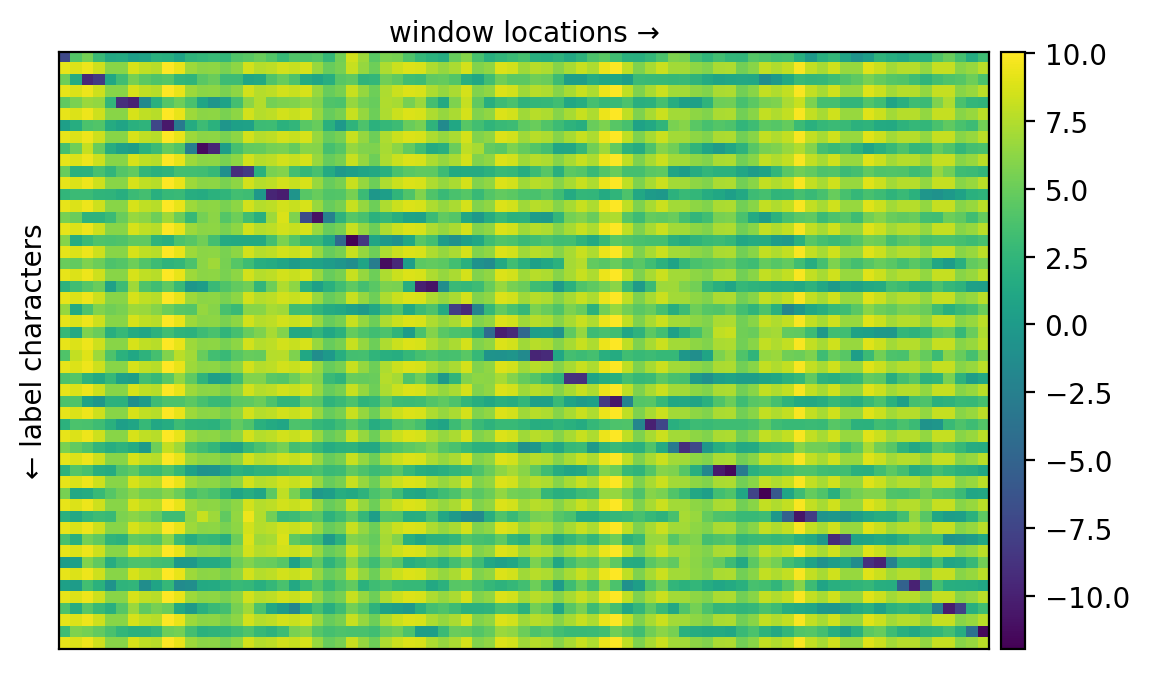

In [13]:
def plot_pm(pm, path=None):
    fig=plt.figure(dpi=200)
    ax = plt.axes()
    im = ax.imshow(pm.cpu().T)
    
    ax.set_xlabel('window locations →')
    ax.set_ylabel('← label characters')
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([])
    ax.set_yticks([])
    
    if path is not None:
        for i in range(len(path) - 1):
            ax.plot(*path[i], *path[i+1], marker = 'o', markersize=0.5, linewidth=10, color='r', alpha=1)

    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax) 
    
energies = model(alphabet.cuda().view(1, 1, *alphabet.shape))
targets = transform_word(string.ascii_lowercase).unsqueeze(0)

print(energies.shape)
print(targets.shape)

pm = build_path_matrix(energies, targets)
print(pm.shape)
plot_pm(pm[0].detach())

What do you see? What does the model classify correctly, and what does it have problems with?

Answer: 
From left to right, we can see character a-z is sequentially lit up which means characters a-z are classified correctly. 
The problem is that it cannot classify the space between two characters.

Searching for a good pairing $z$ is same as searching for a trajectory with a small sum of it's values in this `pm` matrix. Where does the trajectory start, and where does it end? What other properties does the trajectory have? Can you see where an optimal trajecotry would be passing through in the plot above?

Answer: 
In the `pm` matrix which is [L*T], the trajectory starts from [0,0] and ends at [L-1,T-1].
In the above energy table, the optimal trajectory starts from top-left and ends at bottom-right through the diagonal line.



Now let's implement a function that would tell us the energy of a particular path (i.e. pairing).

In [14]:
def path_energy(pm, path):
    # inputs:
    #   pm - a matrix of energies [L, T]
    #    L - energies length
    #    T - targets length
    #   path - list of length L that maps each energy vector to an element in T
    # returns:
    #   energy - sum of energies on the path, or 2**30 if the mapping is invalid
    error = torch.tensor([2**30])
    L,T = pm.shape
    if len(path) != L or path[0] != 0 or path[L-1] != T-1:
      return error
    
    sum = pm[0,0]
    for i in range(1, L):
      if path[i] != path[i-1] and path[i] != path[i-1]+1:
        return error
      sum = sum + pm[i,path[i]]
    
    return torch.tensor([sum])

Now we can check some randomly generated paths and see the associated energies for our alphabet image:

energy is 325.6422424316406


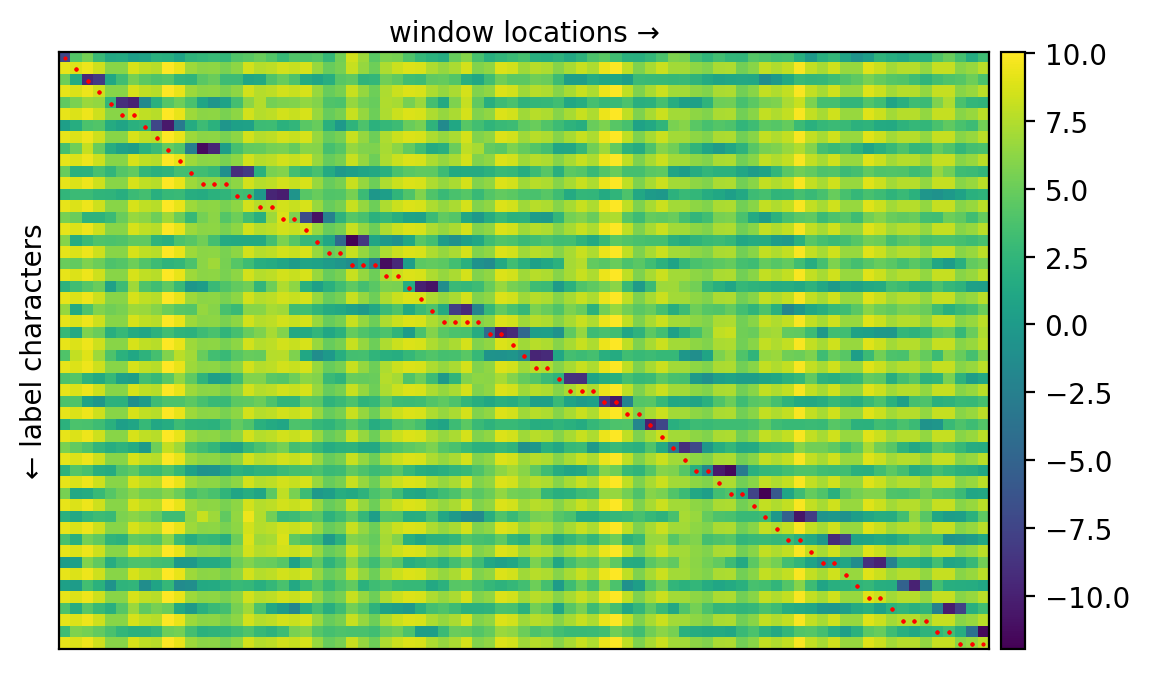

In [15]:
path = torch.zeros(energies.shape[1] - 1)
path[:targets.shape[1] - 1] = 1
path = [0] + list(map(lambda x : x.int().item(), path[torch.randperm(path.shape[0])].cumsum(dim=-1)))
points = list(zip(range(energies.shape[1]), path))

# print(len(path))
# print(path)

plot_pm(pm[0].detach(), points)
print('energy is', path_energy(pm[0], path).item())

Now, generate two paths with the worst possible energy, print their energies and plot them.

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
worst path1, energy is 331.3326721191406
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51]
worst path2, energy is 475.1354675292969


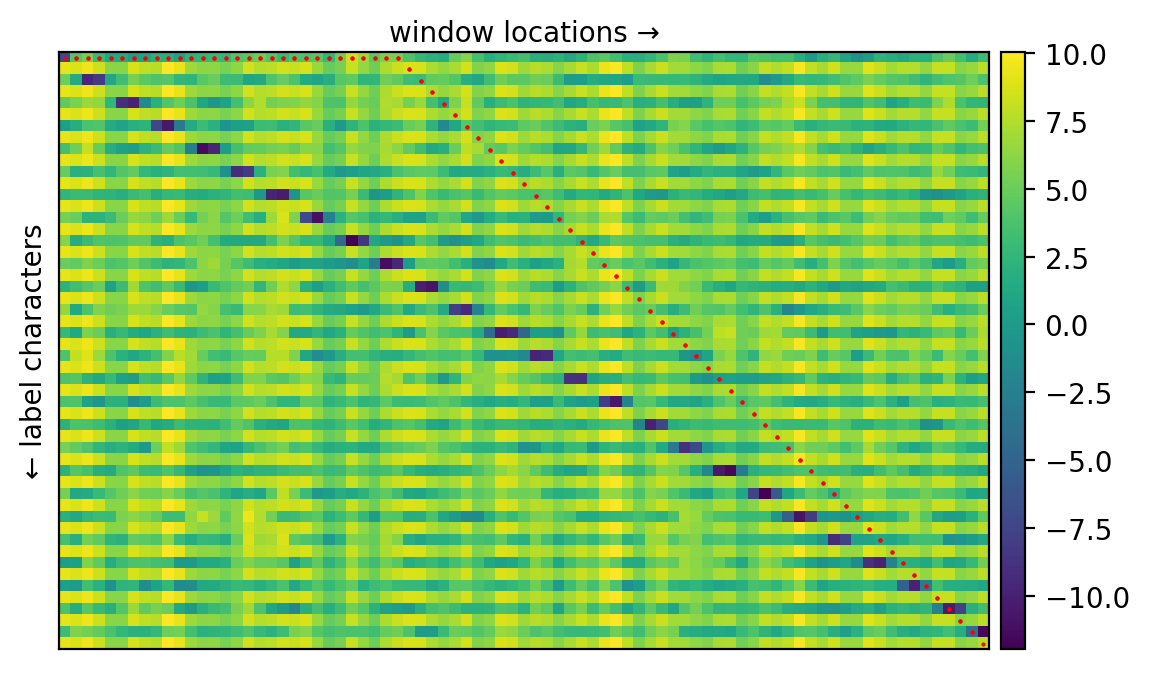

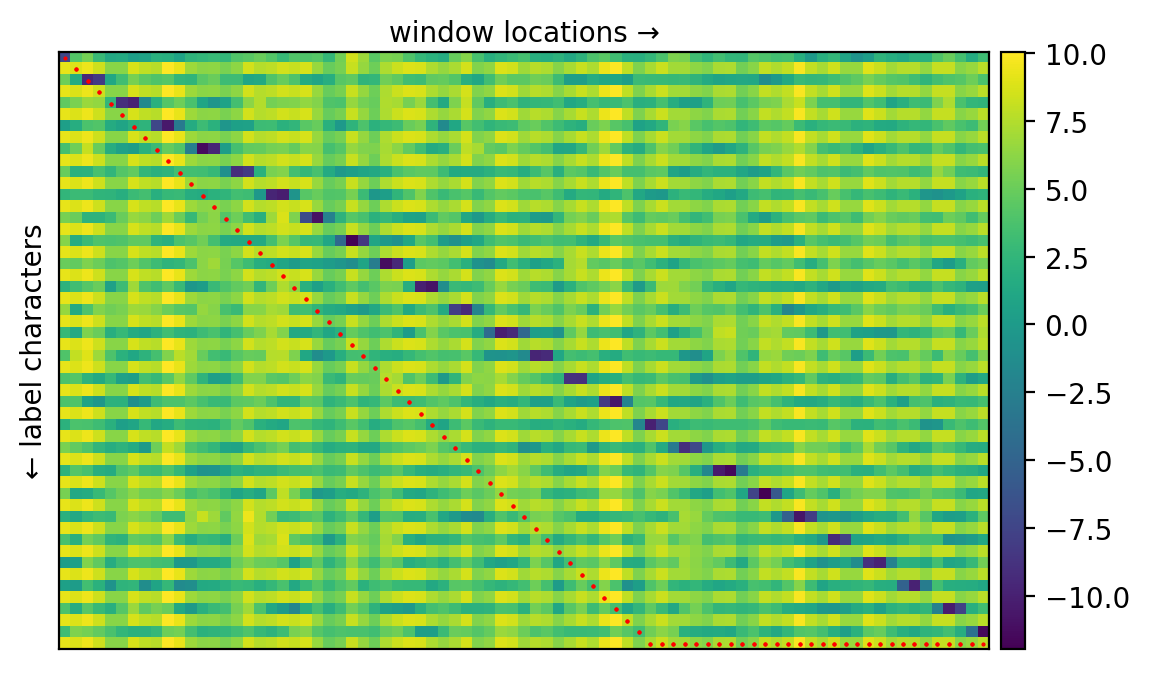

In [16]:
# TODO
#------------path1----------------------------------- go right then diagonal
path1 = [0] * energies.shape[1]
j = energies.shape[1] - targets.shape[1]
for i in range(j, energies.shape[1]):
  path1[i] = i - j

# print(len(path))
print(path1)
points1 = list(zip(range(energies.shape[1]), path1))

plot_pm(pm[0].detach(), points1)
print('worst path1, energy is', path_energy(pm[0], path1).item())

#------------path2----------------------------------- go diagonal then right
path2 = [targets.shape[1] - 1] * energies.shape[1]
for i in range(targets.shape[1]):
  path2[i] = i

# print(len(path))
print(path2)
points2 = list(zip(range(energies.shape[1]), path2))

plot_pm(pm[0].detach(), points2)
print('worst path2, energy is', path_energy(pm[0], path2).item())

### Optimal path finding
Now, we're going to implement the finding of the optimal path. To do that, we're going to use Viterbi algorithm, which in this case is a simple dynamic programming problem.
In this context, it's a simple dynamic programming algorithm that for each pair i, j, calculates the minimum cost of the path that goes from 0-th index in the energies and 0-th index in the target, to i-th index in the energies, and j-th index in the target. We can memorize the values in a 2-dimensional array, let's call it `dp`. Then we have the following transitions:
```
dp[0, 0] = pm[0, 0]
dp[i, j] = min(dp[i - 1, j], dp[i - 1, j - 1]) + pm[i, j]
```

The optimal path can be recovered if we memorize which cell we came from for each `dp[i, j]`.

Below, you'll need to implement this algorithm:

In [17]:
def find_path(pm):
    # inputs:
    #   pm - a tensor of shape LxT with energies
    #     L is length of energies array
    #     T is target sequence length
    # NOTE: this is slow because it's not vectorized to work with batches.
    #  output:
    #     a tuple of three elements:
    #         1. sum of energies on the best path --- free_eneger (tensor)
    #         2. list of tuples - points of the best path in the pm matrix --- path (list of tuples)
    #         3. the dp array --- dp (tensor)

    # TODO
    L,T = pm.shape
    dp = torch.zeros(L,T)
    dp.fill_(2**30)
    dp[0, 0] = pm[0, 0]

    for i in range(1,L):
      dp[i, 0] = dp[i - 1, 0] + pm[i, 0]
      for j in range(1,T):
        dp[i, j] = min(dp[i - 1, j], dp[i - 1, j - 1]) + pm[i, j]

    path = [(0,0)]*L
    path[L-1] = (L-1, T-1)

    last = T-1
    for i in reversed(range(1,L-1)):
      if last == 0:
        path[i] = (i, last)
      elif last != i+1 and dp[i, last] < dp[i, last - 1]:
        path[i] = (i, last)
      else:
        path[i] = (i, last - 1)
        last = last - 1

    return (dp[L-1, T-1], path, dp)

Let's take a look at the best path:

[(0, 0), (1, 1), (2, 2), (3, 2), (4, 3), (5, 4), (6, 4), (7, 5), (8, 6), (9, 6), (10, 6), (11, 7), (12, 8), (13, 8), (14, 9), (15, 10), (16, 10), (17, 11), (18, 12), (19, 12), (20, 13), (21, 14), (22, 14), (23, 15), (24, 16), (25, 16), (26, 16), (27, 17), (28, 18), (29, 18), (30, 19), (31, 20), (32, 20), (33, 21), (34, 22), (35, 22), (36, 23), (37, 24), (38, 24), (39, 24), (40, 25), (41, 26), (42, 26), (43, 27), (44, 28), (45, 28), (46, 29), (47, 30), (48, 30), (49, 30), (50, 31), (51, 32), (52, 32), (53, 33), (54, 34), (55, 34), (56, 35), (57, 36), (58, 36), (59, 37), (60, 38), (61, 38), (62, 38), (63, 39), (64, 40), (65, 40), (66, 41), (67, 42), (68, 42), (69, 43), (70, 44), (71, 44), (72, 45), (73, 46), (74, 46), (75, 47), (76, 48), (77, 48), (78, 49), (79, 50), (80, 51)]
free energy is -295.6317138671875


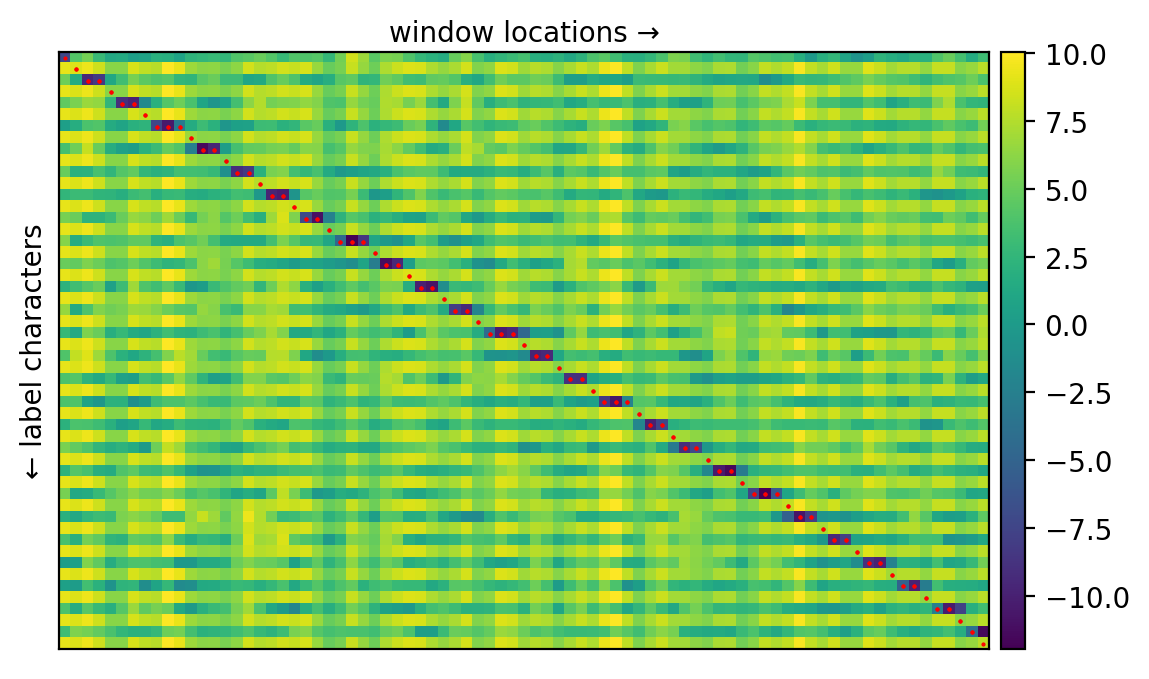

In [18]:
free_energy, path, d = find_path(pm[0])
plot_pm(pm[0].detach(), path)
print(path)
print('free energy is', free_energy.item())

We can also visualize the dp array. You may need to tune clamping to see what it looks like.

(-0.5, 80.5, 51.5, -0.5)

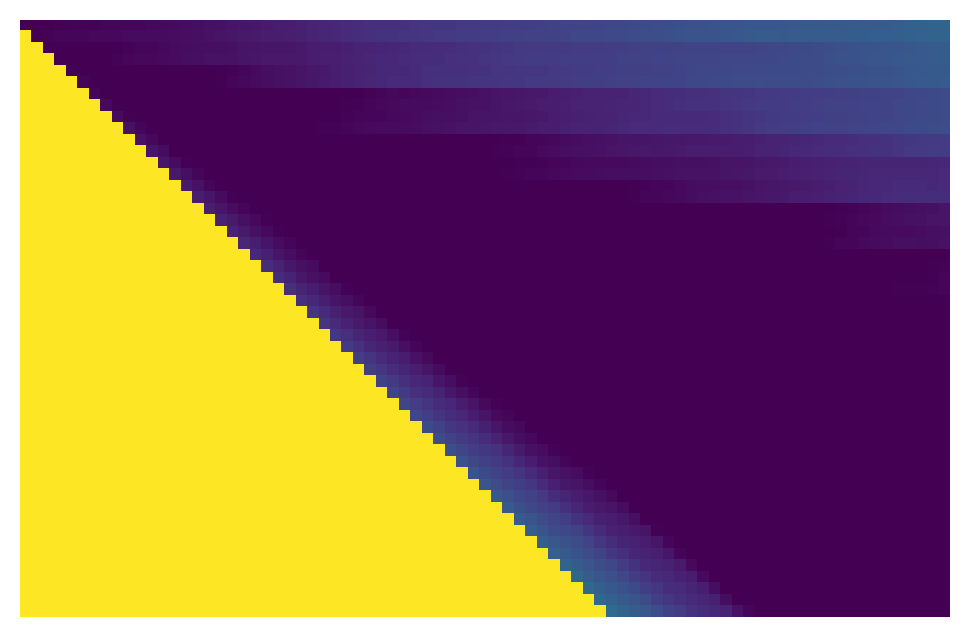

In [19]:
plt.figure(dpi=200)
plt.imshow(d.cpu().detach().T.clamp(0, 750))
plt.axis('off')

### Training loop
Now is time to train the network using our best path finder. We're going to use the energy loss function:
$$\ell(x, y) = \sum_i H(y_{z(i)}, l_i)$$
Where $z$ is the best path we've found. This is akin to pushing down on the free energy $F(x, y)$, while pushing up everywhere else by nature of cross-entropy.

In [20]:
def collate_fn(samples):
    """ A function to collate samples into batches for multi-character case"""
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(transform_word, annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    m_length = max(3, max([s.shape[0] for s in annotations]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(images[i], (0, m_width - images[i].shape[-1]))
        annotations[i] = torch.nn.functional.pad(annotations[i], (0, m_length - annotations[i].shape[0]), value=BETWEEN)
    if len(images) == 1:
        return images[0].unsqueeze(0), torch.stack(annotations)
    else:
        return torch.stack(images), torch.stack(annotations)
    
sds = SimpleWordsDataset(2, 2500) # for simplicity, we're training only on words of length two
# sds = SimpleWordsDataset(3, 2500) # training only on words of length 3

BATCH_SIZE = 32
dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)

# TODO: train the model
# note: remember that our best path finding algorithm is not batched, so you'll
# need a for loop to do loss calculation. 
# This is not ideal, as for loops are very slow, but for 
# demonstration purposes it will suffice. In practice, this will be
# unusable for any real problem unless it handles batching.

# also: remember that the loss is the sum of cross_entropies along the path, not 
# energies!

def trainNet(model, batch, optimizer, device):
    x = batch[0].unsqueeze(1).to(device) # torch.Size([32, 32, 36]) => torch.Size([32, 1, 32, 36])
    y = batch[1].to(device).long()   # torch.Size([31, 4])
    batch_size = x.shape[0]
    T = y.shape[1]

    # feed data
    energies = model(x) # torch.Size([32,5,27])
    L = energies.shape[1]

    pm = build_path_matrix(energies, y)
    ce = build_ce_matrix(energies, y)
    # loss
    loss = 0
    for b in range(batch_size):
      (free_energy, best_path, dp) = find_path(pm[b])
      lossB = 0
      for i in range(L):
        lossB = lossB + ce[b,i,best_path[i][1]]
      loss += lossB

    # zero gradient
    optimizer.zero_grad()
    # back-propagate
    loss.backward()
    # optimize
    optimizer.step()

epochs = 15

learning_rate = 1e-3
lambda_l2 = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

pbar = tqdm(range(epochs))
model.train()

for i in pbar:
    for batch in tqdm(dataloader, leave=False):
        trainNet(model, batch, optimizer, device)


Let's check what the energy matrix looks like for the alphabet image now.

[(0, 0), (1, 1), (2, 2), (3, 2), (4, 3), (5, 4), (6, 4), (7, 5), (8, 5), (9, 6), (10, 6), (11, 7), (12, 8), (13, 8), (14, 9), (15, 9), (16, 10), (17, 11), (18, 12), (19, 12), (20, 13), (21, 14), (22, 14), (23, 15), (24, 15), (25, 16), (26, 16), (27, 17), (28, 17), (29, 18), (30, 19), (31, 20), (32, 20), (33, 21), (34, 21), (35, 22), (36, 23), (37, 23), (38, 24), (39, 24), (40, 25), (41, 26), (42, 26), (43, 27), (44, 28), (45, 28), (46, 29), (47, 29), (48, 30), (49, 31), (50, 31), (51, 32), (52, 32), (53, 33), (54, 34), (55, 34), (56, 35), (57, 36), (58, 36), (59, 37), (60, 37), (61, 38), (62, 38), (63, 39), (64, 40), (65, 40), (66, 41), (67, 42), (68, 42), (69, 43), (70, 44), (71, 44), (72, 45), (73, 45), (74, 46), (75, 47), (76, 47), (77, 48), (78, 49), (79, 50), (80, 51)]
free energy is -372.87652587890625


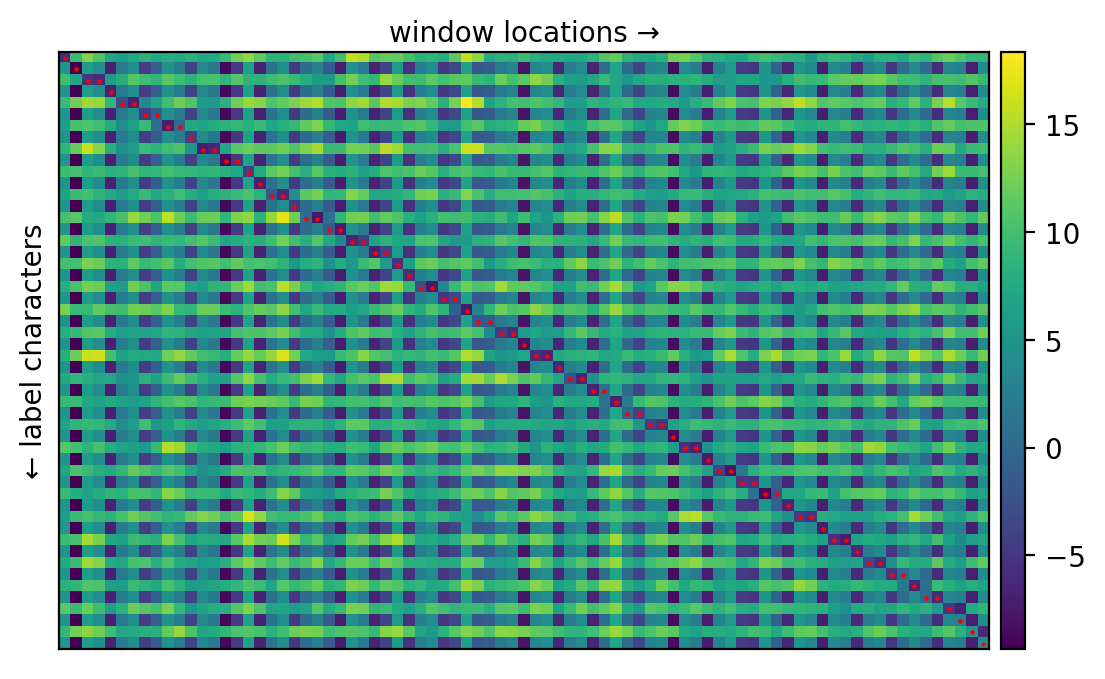

In [21]:
energies = model(alphabet.unsqueeze(0).unsqueeze(0).cuda())
targets = transform_word(string.ascii_lowercase)
pm = build_path_matrix(energies, targets.unsqueeze(0))

free_energy, path, _ = find_path(pm[0])
plot_pm(pm[0].detach(), path)
print(path)
print('free energy is', free_energy.item())

Explain how the free energy changed, and why.

Answer: 
The free energy goes down after training. Because we pushed down on the free energy 𝐹(𝑥,𝑦), while pushed up everywhere else by nature when training this model. The free energy is the energy along the best path. So after training, the free energy may go down. But the free energy here can refer to a different path other than the best path.

We can also look at raw energies output:

(-0.5, 80.5, 26.5, -0.5)

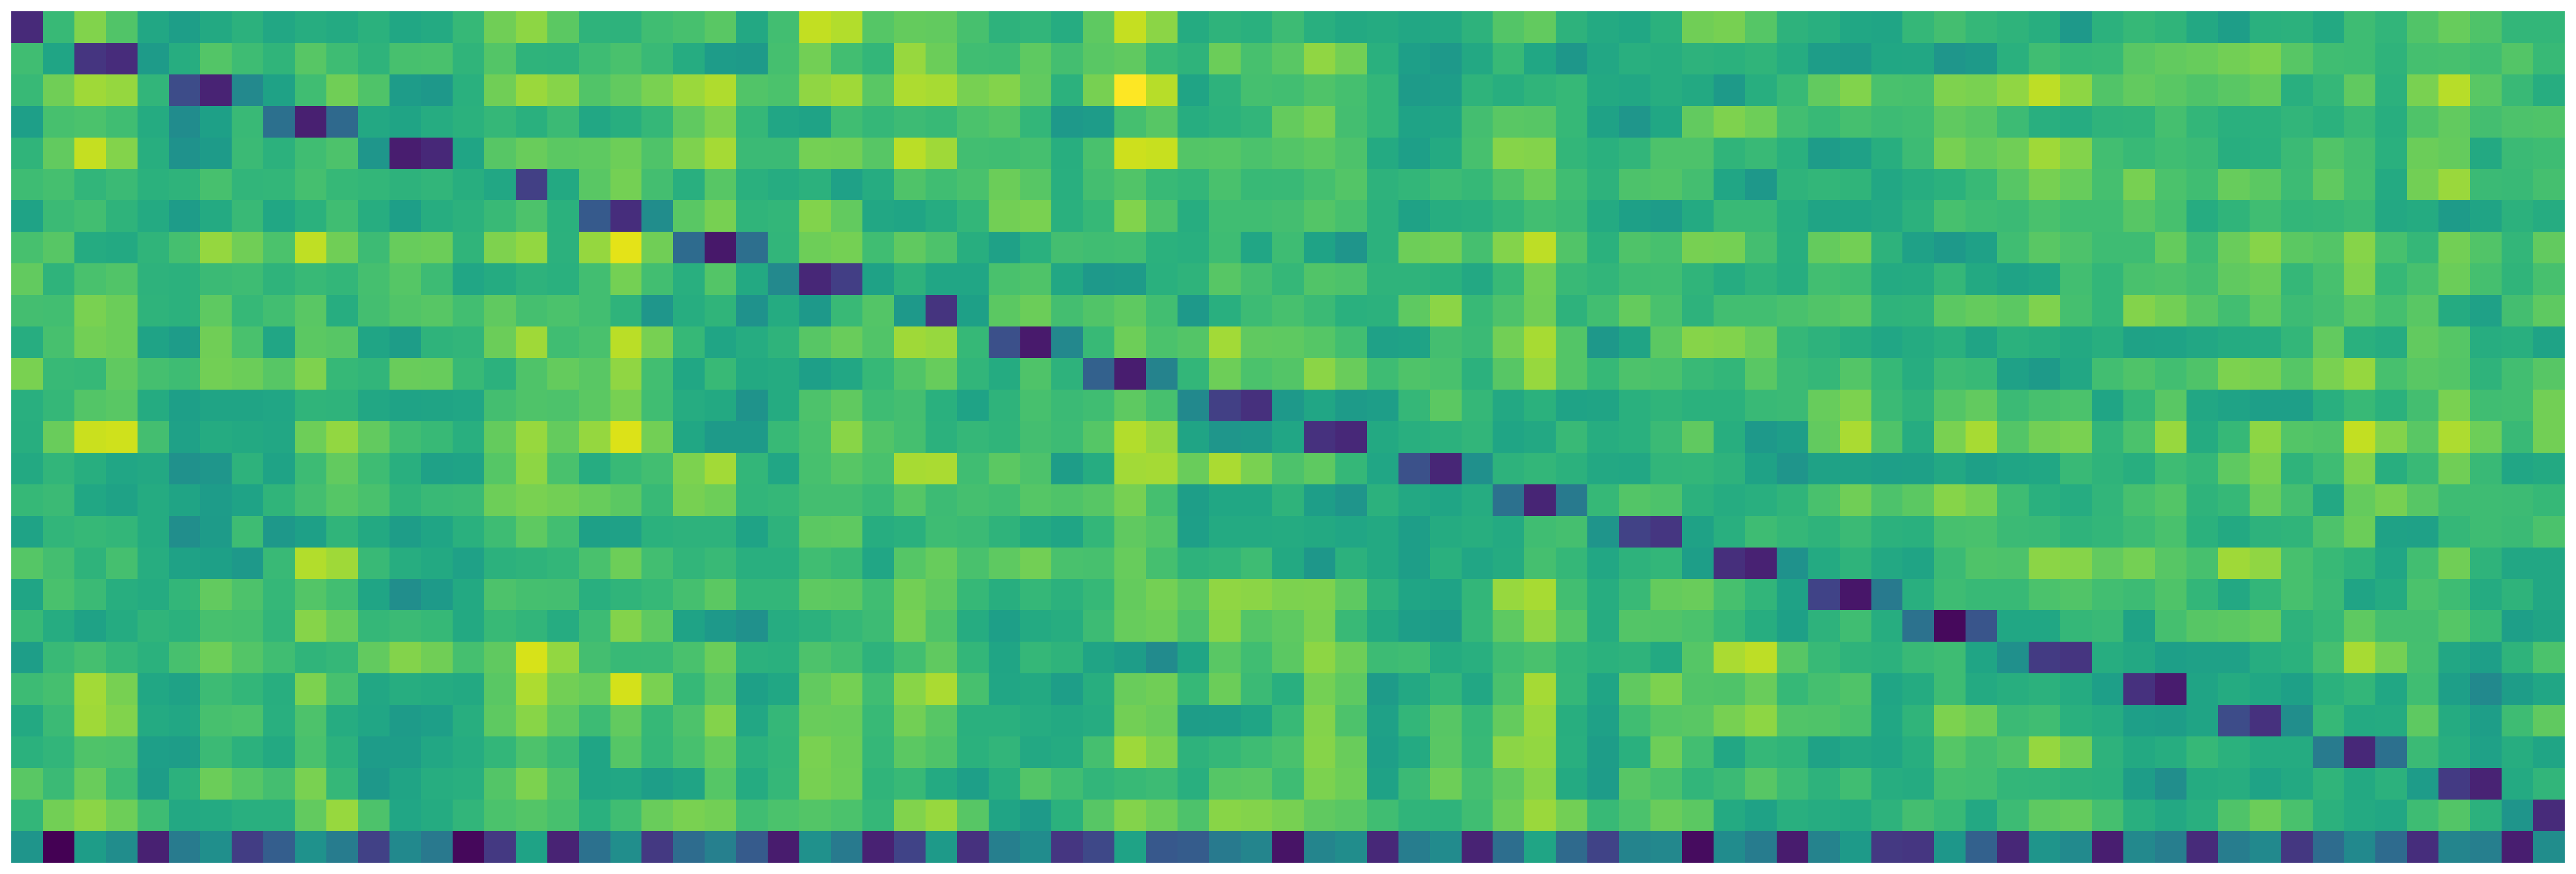

In [22]:
alphabet_energy_post_train_viterbi = model(alphabet.cuda().view(1, 1, *alphabet.shape))

plt.figure(dpi=200, figsize=(40, 10))
plt.imshow(alphabet_energy_post_train_viterbi.cpu().data[0].T)
plt.axis('off')

How does this compare to the energies we had after training only on one-character dataset?

Answer: 
In this plot, the space class is lit up. This means this model can reconize space class now.

## Decoding

Now we can use the model for decoding a word from an image. Let's pick some word, apply the model to it, and see energies. 

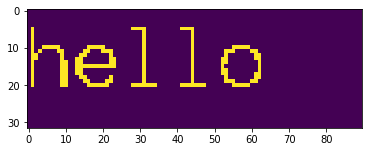

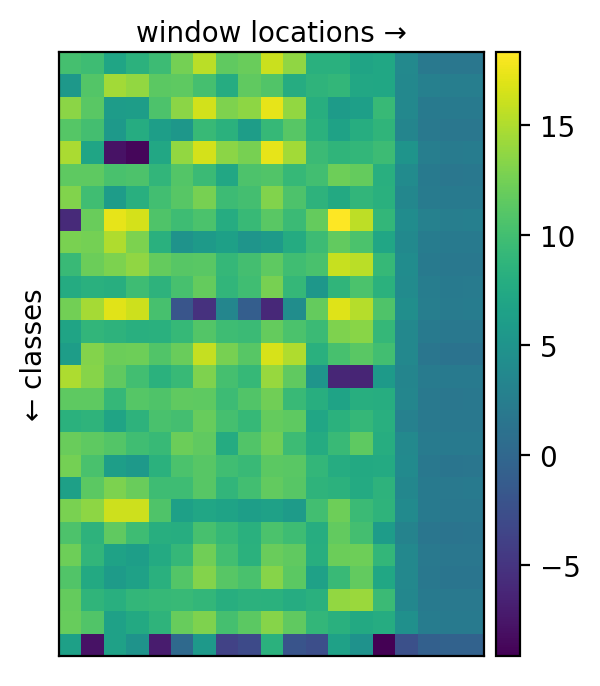

In [23]:
img = sds.draw_text('hello')
energies = model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())

You should see some characters light up. Now, let's implement a simple decoding algorithm. To decode, first we want to get most likely classes for all energies, and then do two things:
1. segment strings using the divisors (our special character with index 26), and for each segment replace it with the most common character in that segment. Example: aaab_bab_ -> a_b. If some characters are equally common, you can pick random.
2. remove all special divisor characters: a_b -> ab


In [24]:
def indices_to_str(indices):
    # inputs: indices - a tensor of most likely class indices
    # outputs: decoded string
    res = ""
    cur = [0]*26

    for i in range(indices.shape[0]):
      if (indices[i] == 26):
        k = -1
        for j in range(26):
          if k == -1 and cur[j] > 0:
            k = j
          elif k != -1 and cur[j] >= cur[k]:
            k = j
        if k != -1:
          res += chr(k+97)
        cur = [0]*26
      else:
        cur[indices[i]] += 1
    
    return res

min_indices = energies[0].argmin(dim=-1)
print(indices_to_str(min_indices))

hello


## Test

hahagood


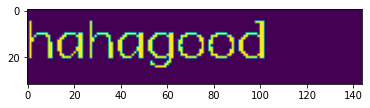

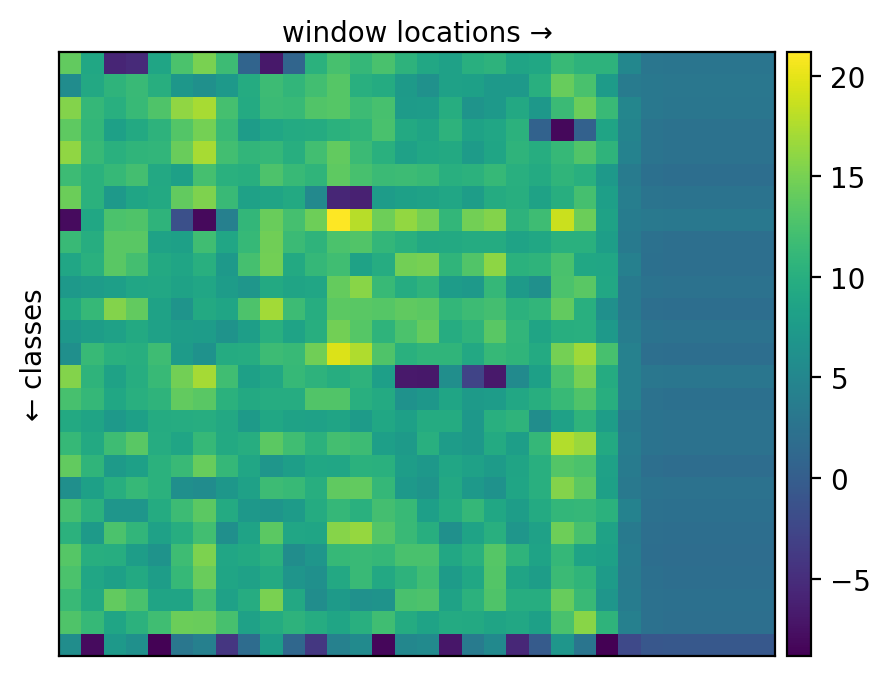

In [25]:
img = sds.draw_text('hahagood')
energies = model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())
min_indices = energies[0].argmin(dim=-1)
print(indices_to_str(min_indices))

tensor([ 7, 26,  4,  4, 26, 11, 11, 26, 26, 11, 26, 26, 14, 14, 26, 26, 26, 26,
        22, 22, 26, 14, 14, 26, 26, 17, 17, 26, 11, 11, 26,  3,  3, 26, 26, 26,
        26, 22, 22, 22, 26,  4,  4, 26, 11, 11, 26,  2,  2,  2, 26, 14, 14, 26,
        12, 12, 26,  4,  4, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26], device='cuda:0')
helloworldwelcome


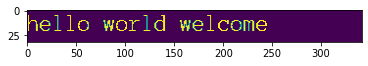

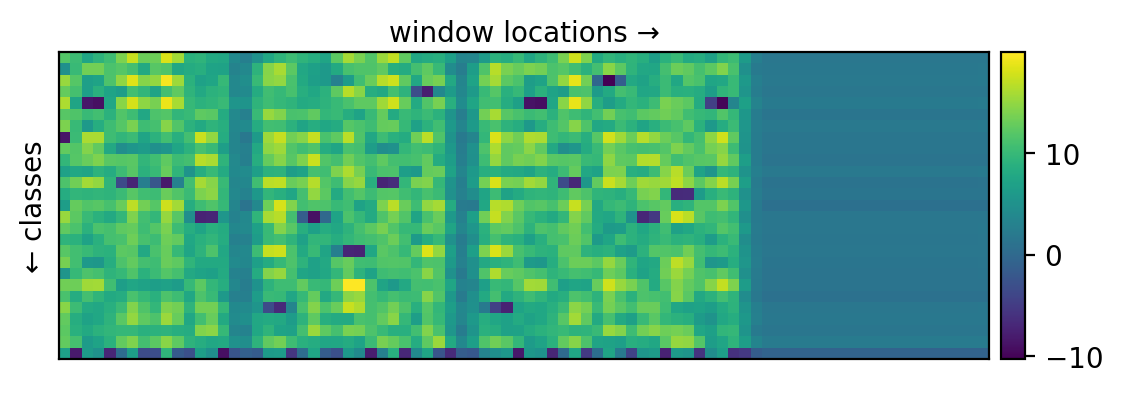

In [26]:
img = sds.draw_text('hello world welcome')
energies = model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())
min_indices = energies[0].argmin(dim=-1)
print(min_indices)
print(indices_to_str(min_indices))

excellent


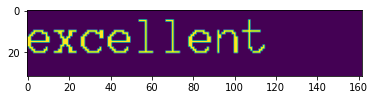

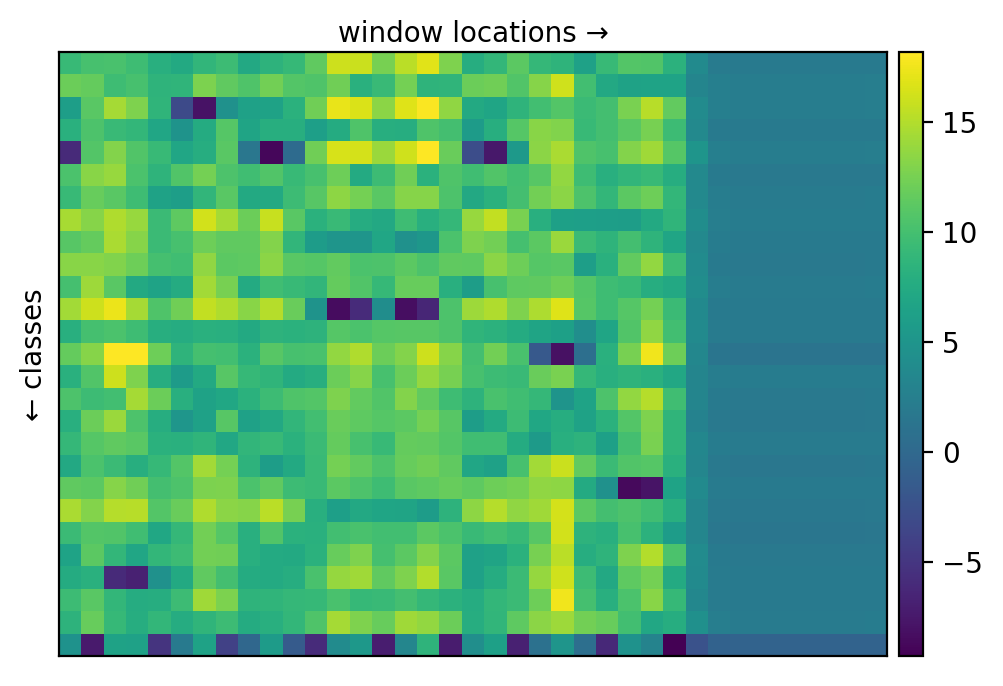

In [27]:
img = sds.draw_text('excellent')
energies = model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())
min_indices = energies[0].argmin(dim=-1)
print(indices_to_str(min_indices))